In [64]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from geopy import distance

import sklearn
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans


os.getcwd()

'c:\\Users\\johnc\\Documents\\Python Scripts\\ocean-depth-characterization\\EDA'

In [65]:
PROFILE_DATA_PATH = "../data/profileData.csv"
SAT_DATA_PATH = "../data/satData.csv"

profile_df = pd.read_csv(PROFILE_DATA_PATH)
sat_df = pd.read_csv(SAT_DATA_PATH)

In [66]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37469410 entries, 0 to 37469409
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   float        int64  
 1   cycleNumber  int64  
 2   date         object 
 3   PRES         int64  
 4   PSAL         float64
 5   TEMP         float64
 6   BBP700       float64
 7   CHLA         float64
dtypes: float64(4), int64(3), object(1)
memory usage: 2.2+ GB


In [67]:
sat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66271 entries, 0 to 66270
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   float           66271 non-null  int64  
 1   cycleNumber     66271 non-null  int64  
 2   date            66271 non-null  object 
 3   latitude        66271 non-null  float64
 4   longitude       66271 non-null  float64
 5   elevation       66271 non-null  float64
 6   MO_SAT_SST      62358 non-null  float64
 7   MO_SAT_CHL      52921 non-null  float64
 8   MO_SAT_BBP      52760 non-null  float64
 9   LT_SAT_SST_SD   62993 non-null  float64
 10  LT_SAT_SST_MED  62994 non-null  float64
 11  LT_SAT_CHL_SD   66267 non-null  float64
 12  LT_SAT_CHL_MED  62991 non-null  float64
 13  LT_SAT_BBP_SD   62990 non-null  float64
 14  LT_SAT_BBP_MED  62991 non-null  float64
dtypes: float64(12), int64(2), object(1)
memory usage: 7.6+ MB


In [68]:
float_ids = np.unique(profile_df.float)
num_floats = len(float_ids)
print(f"Total number of floats with proper sensors: {num_floats}")

Total number of floats with proper sensors: 569


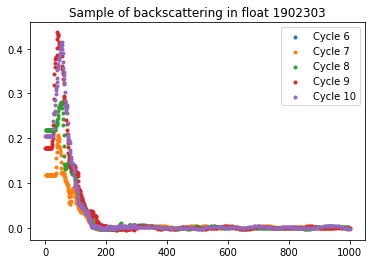

In [118]:
float = profile_df[profile_df.float == np.random.choice(float_ids)]
for i in range(5):
    plt.scatter(float[float.cycleNumber == i].PRES, float[float.cycleNumber == i].CHLA, marker=".")
plt.legend([f"Cycle {i+1}" for i in range(5, 10)])
plt.title("Sample of backscattering in float {}".format(float_ids[0]))
plt.show()

In [70]:
cycle1 = profile_df[profile_df.cycleNumber == 8]

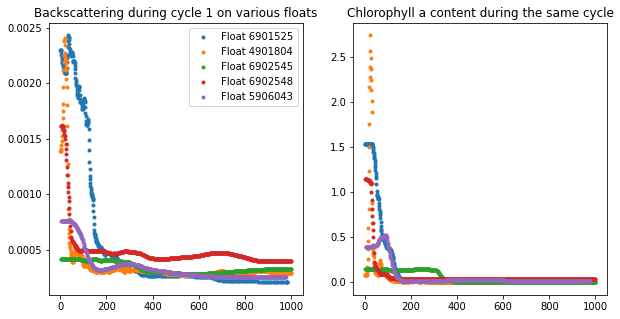

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
float_ls = np.random.choice(float_ids, size=5)
for rand_float in float_ls:
    ax[0].scatter(cycle1[cycle1.float == rand_float].PRES, cycle1[cycle1.float == rand_float].BBP700, marker=".")
    ax[1].scatter(cycle1[cycle1.float == rand_float].PRES, cycle1[cycle1.float == rand_float].CHLA, marker=".")
ax[0].legend([f"Float {f}" for f in float_ls])
ax[0].set_title("Backscattering during cycle 1 on various floats")
ax[1].set_title("Chlorophyll a content during the same cycle")
plt.show()

In [72]:
# Aggregate profile data using the mean value of chlorophyll a and bbp700 nm in the sunlit portion of the ocean
sunlit_profiles = profile_df[profile_df.PRES < 10][['float', 'cycleNumber', 'CHLA', 'BBP700']] \
    .groupby(['float', 'cycleNumber']).mean().reset_index()
df_merged = sat_df.merge(sunlit_profiles, on=['float', 'cycleNumber']).drop(['LT_SAT_SST_SD', 'LT_SAT_SST_MED'], axis=1).dropna()

### Separating merged data into mini time series periods

In [73]:
def create_period_data(merged_df):
    df = merged_df.copy()
    # create datetime column
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d %H:%M:%S')
    # find splits between cycles in DAYS
    df['delta'] = ((df.date - df.date.shift()).dt.total_seconds() / 3600).fillna(0)
    # turn all cyclenumber 1s into 0 delta
    df.loc[df.cycleNumber == 1, 'delta'] = 0
    # start cycle over if time delta is over 15 days (360 hours)
    df.loc[(df.delta > 408) | (df.delta < 0), 'delta'] = 0
    # make a flag column for row at the end of a period
    df = df.reset_index().drop('index', axis=1)
    period_ls = list()
    period = 0
    for i, r in df.iloc[:-1].iterrows():
        if r['delta'] != 0:
            period_ls.append(period)
        else:
            r1 = df.iloc[i+1]
            if r1['delta'] != 0:
                period += 1
                period_ls.append(period)
            else:
                period_ls.append(np.nan)
    if df.iloc[-1]['delta'] != 0:
        period_ls.append(period)
    else:
        period_ls.append(np.nan)
    df['period'] = period_ls
    df = df.dropna()
    return df

df = create_period_data(df_merged)

In [74]:
15*24

360

<AxesSubplot:xlabel='delta', ylabel='Count'>

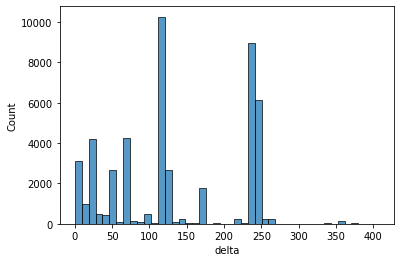

In [75]:
sns.histplot(df.delta)

In [76]:
def get_distance_series(df):
    dist_from_last = [0]
    if df.shape[0] > 1:
            for i, r in df.iloc[1:].iterrows():
                last_loc = (df.iloc[i-1].latitude, df.iloc[i-1].longitude)
                new_loc = (r.latitude, r.longitude)
                dist_from_last.append(distance.distance(last_loc, new_loc).km)
    else:
        return 0
    return dist_from_last

def gather_period_observations(df, plot=False, print_results=False):
    period_df = df.copy()
    period_df['dists_from'] = get_distance_series(period_df)
    beg_lat = period_df.iloc[0].latitude
    beg_lon = period_df.iloc[0].longitude
    info_dict = {
        'float_no': period_df.iloc[0].float,
        'period_no': period_df.iloc[0].period,
        'start_date': period_df.iloc[0].date,
        'end_date': period_df.iloc[-1].date,
        'num_cycles': period_df.shape[0],
        'avg_obsv_gap_days': period_df[1:].delta.mean() / 24,
        'total_dist_km': period_df.dists_from.sum()
    }

    if print_results:
        print(f'Float no: {period_df.iloc[0].float}\nPeriod no: {period_df.iloc[0].period}\nStart Date: {period_df.iloc[0].date}\nEnd Date: {period_df.iloc[-1].date}')
        print(f'Observations: {period_df.shape[0]}\nAvg Time Delta: {period_df[1:].delta.mean() / 24:.2f} Days\nTotal Distance Traveled: {period_df.dists_from.sum():.2f} km')
    
    if plot:
        fig = px.density_mapbox(period_df, lat='latitude', lon='longitude', z='MO_SAT_CHL', radius=8, center=dict(lat=beg_lat, lon=beg_lon), zoom=2, mapbox_style='stamen-terrain')
        fig.show()

    return info_dict

In [117]:
rand_period = np.random.choice(df.period, 5)
rand_period_df = df[df.period.isin(rand_period)].reset_index().drop('index', axis=1).reset_index()
_ = gather_period_observations(rand_period_df, plot=True)

In [78]:
periods = np.unique(df.period)
summary_data = [gather_period_observations(df[df.period == p].reset_index()) for p in periods]
summary_df = pd.DataFrame(summary_data)

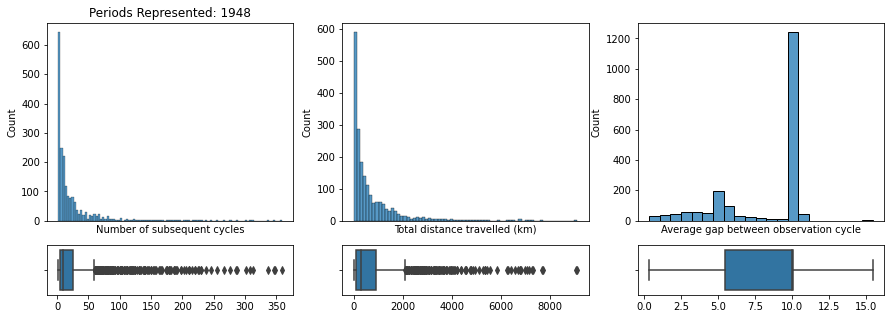

In [79]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5), gridspec_kw={"height_ratios": (.8, .2)})

ax[0, 0].set_title(f'Periods Represented: {summary_df.shape[0]}')

sns.histplot(data=summary_df, x='num_cycles', ax=ax[0, 0])
sns.boxplot(data=summary_df, x='num_cycles', ax=ax[1, 0])
ax[1, 0].set_xlabel('')
ax[0, 0].tick_params(bottom=False, labelbottom=False)
ax[0, 0].set_xlabel('Number of subsequent cycles')

sns.histplot(data=summary_df, x='total_dist_km', ax=ax[0, 1])
sns.boxplot(data=summary_df, x='total_dist_km', ax=ax[1, 1])
ax[1, 1].set_xlabel('')
ax[0, 1].tick_params(bottom=False, labelbottom=False)
ax[0, 1].set_xlabel('Total distance travelled (km)')

sns.histplot(data=summary_df, x='avg_obsv_gap_days', ax=ax[0, 2])
sns.boxplot(data=summary_df, x='avg_obsv_gap_days', ax=ax[1, 2])
ax[1, 2].set_xlabel('')
ax[0, 2].tick_params(bottom=False, labelbottom=False)
ax[0, 2].set_xlabel('Average gap between observation cycle')

plt.show()

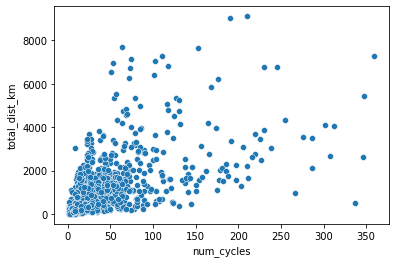

In [87]:
sns.scatterplot(data=summary_df, x='num_cycles', y='total_dist_km')
high_len_periods = summary_df[summary_df.total_dist_km > 4000].period_no

**Correlation between period CHLA distributions**

In [81]:
df_period_merge = profile_df.merge(df[['float', 'cycleNumber', 'period', 'latitude', 'longitude', 'MO_SAT_CHL']], on=['float', 'cycleNumber'])

Float no: 2902748
Period no: 244.0
Start Date: 2019-03-31 13:53:53
End Date: 2021-05-11 23:59:22
Observations: 230
Avg Time Delta: 3.37 Days
Total Distance Traveled: 6758.28 km


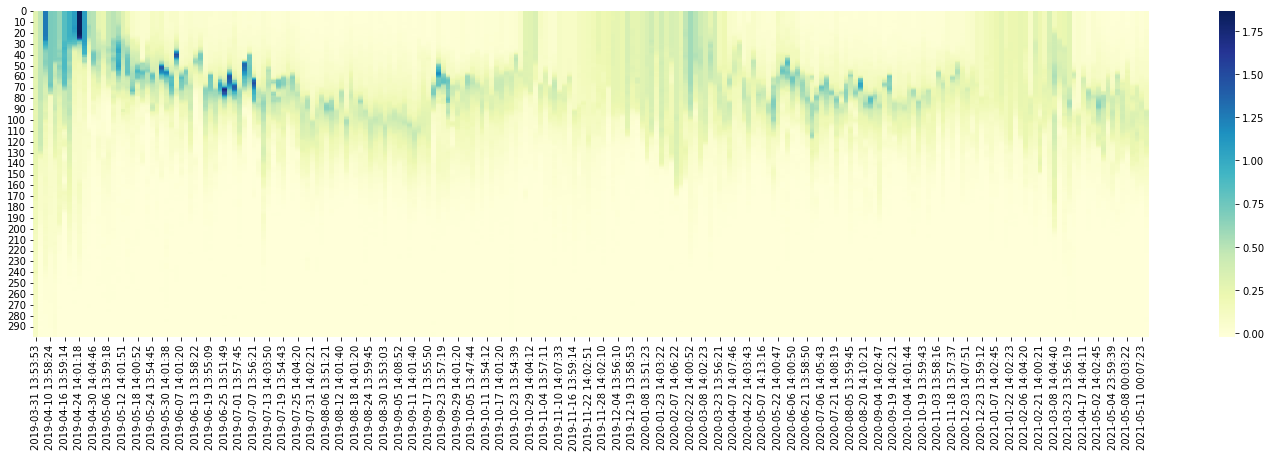

0.3056599522640657

In [116]:
long_period = np.random.choice(high_len_periods)
high_len_df = df_period_merge[df_period_merge.period == long_period]

heatmap = {}
for date in np.unique(high_len_df.date):
    heatmap[date] = high_len_df[high_len_df.date == date].sort_values('PRES').CHLA.to_numpy()[:300]
df_heat = pd.DataFrame(heatmap)

long_period_df = df[df.period == long_period].reset_index().drop('index', axis=1).reset_index()
_ = gather_period_observations(long_period_df, plot=True, print_results=True)
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.heatmap(df_heat, cmap="YlGnBu", ax=ax)
plt.show()

np.triu(df_heat.corr().to_numpy(), k=1).mean()


In [107]:
corrs = list()
for p in np.unique(summary_df.period_no):
    p_df = df_period_merge[df_period_merge.period == p]
    heatmap = {}
    for date in np.unique(p_df.date):
        heatmap[date] = p_df[p_df.date == date][['PRES', 'CHLA']].sort_values('PRES').CHLA.to_numpy()[:250]
        try:
            heat_df = pd.DataFrame(heatmap)
            corrs.append(np.triu(heat_df.corr().to_numpy(), k=1).mean())
        except:
            pass

<AxesSubplot:ylabel='Count'>

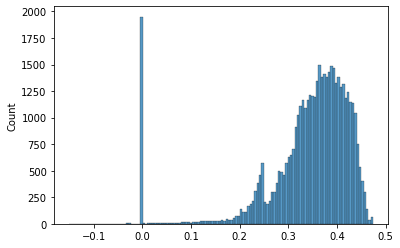

In [110]:
sns.histplot(x=corrs)

### RidgeReg and Corrlelation on Merged Data

In [109]:
df.corr(method="spearman").style.background_gradient()

,float,cycleNumber,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED,CHLA,BBP700,delta,period
float,1.000000,-0.022889,0.283523,-0.133037,0.387262,-0.201853,0.146172,0.010184,0.157789,0.156622,0.009830,0.033728,0.063744,0.041304,-0.273490,0.999996
cycleNumber,-0.022889,1.000000,0.031182,0.071679,-0.013561,0.049737,-0.049370,-0.058731,-0.063233,-0.052914,-0.020424,-0.057188,-0.062060,-0.076029,-0.030380,-0.021221
latitude,0.283523,0.031182,1.000000,-0.124684,0.330924,0.205679,0.171777,-0.296693,0.222795,0.208036,-0.111763,-0.351423,-0.164312,-0.140565,-0.314773,0.283514
longitude,-0.133037,0.071679,-0.124684,1.000000,0.112675,0.004823,0.047980,0.004759,0.079862,0.037156,0.074329,-0.041536,0.072123,0.042978,-0.077576,-0.132986
elevation,0.387262,-0.013561,0.330924,0.112675,1.000000,-0.233183,0.353817,0.024754,0.412881,0.376611,0.212501,0.036361,0.196679,0.176191,-0.169487,0.387250
MO_SAT_SST,-0.201853,0.049737,0.205679,0.004823,-0.233183,1.000000,-0.587878,-0.441552,-0.570437,-0.601446,-0.736313,-0.720455,-0.662072,-0.586250,0.002512,-0.201821
MO_SAT_CHL,0.146172,-0.049370,0.171777,0.047980,0.353817,-0.587878,1.000000,0.434213,0.804691,0.865171,0.726767,0.522985,0.767782,0.726978,-0.061097,0.146067
MO_SAT_BBP,0.010184,-0.058731,-0.296693,0.004759,0.024754,-0.441552,0.434213,1.000000,0.314424,0.386527,0.500428,0.637477,0.561635,0.663707,0.075338,0.010125
LT_SAT_CHL_SD,0.157789,-0.063233,0.222795,0.079862,0.412881,-0.570437,0.804691,0.314424,1.000000,0.918246,0.783237,0.491140,0.621096,0.601698,-0.072405,0.157630
LT_SAT_CHL_MED,0.156622,-0.052914,0.208036,0.037156,0.376611,-0.601446,0.865171,0.386527,0.918246,1.000000,0.830546,0.608107,0.679076,0.651129,-0.071303,0.156495


In [ ]:
Xc = df[["latitude", "MO_SAT_CHL", "LT_SAT_CHL_MED"]]
yc = df["CHLA"]
Xb = df[["latitude", "MO_SAT_BBP", "LT_SAT_BBP_MED"]]
yb = df["BBP700"]

rclf_c = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5, scoring='neg_mean_squared_error').fit(Xc, yc)
print("Initial score for ridgereg [CHLA]: {}".format(rclf_c.score(Xc, yc)))

rclf_b = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5, scoring='neg_mean_squared_error').fit(Xb, yb)
print("Initial score for ridgereg [BBP700]: {}".format(rclf_b.score(Xb, yb)))

Initial score for ridgereg [CHLA]: 0.36016952453696793
Initial score for ridgereg [BBP700]: 0.004898620373892992


**Above** - Linear models won't work well for our data

### Questions / Comments on Neural Net Paper

1. How are the input values giving four "potential density values along the vertical profile" derived? (aren't those theoretically very similar to the output values we are trying to achieve? Are they using some aggregation of past float values based on time / location?)

2. Clarification on the use of Z_norm values and their relationship to attenuation coefficients at very specific wavelengths. Further clarification on the lack of similarity between Z_norm calculation between stratified and mixed water columns. (How are they finding this "statistical optimality")

3. What pieces of the dataset we have in hand are similar to the data they calculated / used (what do we have and what else do we need to calculate to repeat / extend their work)

In [23]:
df['date_doy'] = df['date'].apply(lambda x: pd.Period(x, freq='D').day_of_year)
df['date_doy_rad'] = df['date_doy'] * (np.pi /182.625)
score = list()

In [27]:
Xc_boost = df[["latitude", "longitude", "date_doy_rad", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST"]]
# Xc_boost = df[["latitude", "MO_SAT_CHL", "LT_SAT_CHL_MED", "date_doy_rad"]]
# Xc_boost = df[["latitude", "MO_SAT_CHL", "date_doy_rad", "MO_SAT_SST"]]
yc_boost = df["CHLA"]

X_tr, X_te, y_tr, y_te = train_test_split(Xc_boost, yc_boost, test_size=0.15, random_state=23)

reg = GradientBoostingRegressor(loss="squared_error", random_state=23)
hist = reg.fit(X_tr, y_tr)
score1 = reg.score(X_te, y_te)

score.append(score1)
print(score)

[0.5860343287594103, 0.5871506921257765]


In [28]:
preds = reg.predict(X_te)
mae = mean_absolute_error(y_te, preds)
print(f"Mean absolute error: {mae}")
print(f"Mean pred value: {np.mean(preds)}")
print(f"Std. of preds: {np.std(preds)}")
print(f"Mean label value: {np.mean(y_te)}")
print(f"Std. of labels: {np.std(y_te)}")
print(f"Range of labels: {np.min(y_te)}, {np.max(y_te)}")

Mean absolute error: 0.0920466454568321
Mean pred value: 0.28271655683345065
Std. of preds: 0.2139797570054061
Mean label value: 0.27842482497869875
Std. of labels: 0.26812646490390013
Range of labels: -0.02817023744102982, 4.841698022863519


Z_norm. Depth where phytoplankton cant grow
Z_m = mixed layer depth
Z_e = euphotic zone depth

Ideas:

more profiles are available, so we may need to rely less on past float data

Needs:

figure out what other data we can get from the satellites to use as features


### Check average distance between two date recordings

In [26]:
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d %H:%M:%S')

In [34]:
deltas = list()
for f in np.unique(df.float):
    float_df = df[df.float == f].sort_values(by='date', ascending=True)
    float_df['delta'] = (float_df['date'] - float_df['date'].shift()).fillna(pd.Timedelta('0 days'))
    float_df['delta_hrs'] = float_df['delta'].apply(lambda x: x / np.timedelta64(1, 'D')).astype('float')
    deltas += list(float_df['delta_hrs'])

In [39]:
deltas = np.array(deltas)
deltas_filt = deltas[(deltas < 80) & (deltas > 0)]

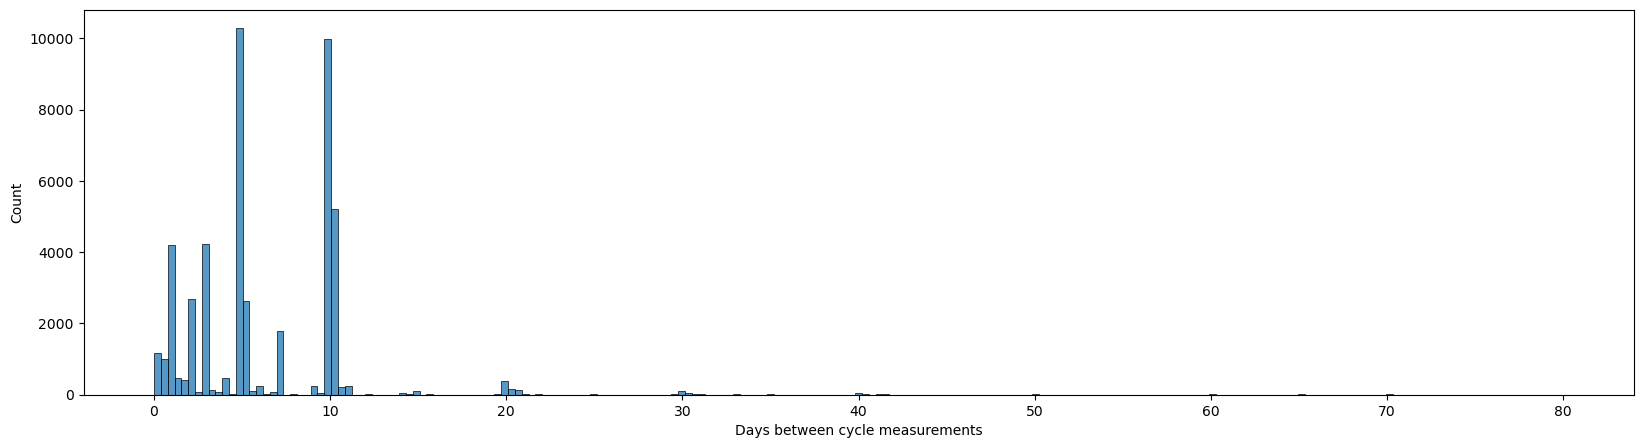

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.histplot(x=deltas_filt, ax=ax)
ax.set_xlabel('Days between cycle measurements')
plt.show()

In [74]:
est = KMeans(n_clusters=6)
groups = est.fit_predict(df[['BBP700', "CHLA"]])

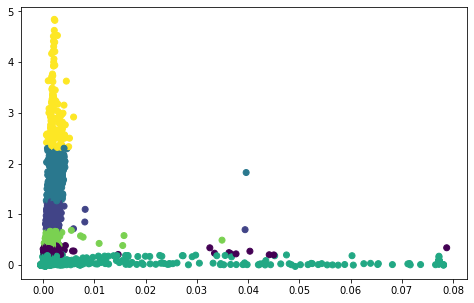

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(df.BBP700.to_list(), df.CHLA.to_list(), c=groups)
plt.show()

In [31]:
profile_df

,float,cycleNumber,date,PRES,PSAL,TEMP,BBP700,CHLA
0,1902303,1,2021-05-06 02:03:16,3,35.539001,12.378333,0.001788,6.958747e-01
1,1902303,1,2021-05-06 02:03:16,4,35.539001,12.378333,0.001788,6.958747e-01
2,1902303,1,2021-05-06 02:03:16,6,35.539001,12.378667,0.001788,6.964993e-01
3,1902303,1,2021-05-06 02:03:16,8,35.539001,12.379000,0.001789,7.164887e-01
4,1902303,1,2021-05-06 02:03:16,10,35.539001,12.379000,0.001790,7.155517e-01
...,...,...,...,...,...,...,...,...
37469405,7901001,28,2022-05-23 11:34:00,968,34.916109,6.358057,0.000216,-3.686869e-05
37469406,7901001,28,2022-05-23 11:34:00,975,34.916280,6.346782,0.000216,-1.843434e-05
37469407,7901001,28,2022-05-23 11:34:00,977,34.916280,6.346782,0.000216,2.543358e-18
37469408,7901001,28,2022-05-23 11:34:00,982,34.916280,6.346782,0.000216,2.543358e-18


In [45]:
depth_profiles = profile_df[['float', 'cycleNumber', 'bins', 'CHLA', 'BBP700']] \
    .groupby(['float', 'cycleNumber', 'depth_bin']).mean().reset_index().dropna()

In [53]:
drop_cols = ['LT_SAT_SST_SD', 'LT_SAT_SST_MED', 'LT_SAT_CHL_SD', 'LT_SAT_CHL_MED', 'LT_SAT_BBP_SD', 'LT_SAT_BBP_MED']
df_depth = depth_profiles.merge(sat_df, on=['float', 'cycleNumber']).drop(drop_cols, axis=1).dropna()

### Data Merging and Binning

In [10]:
PROFILE_DATA_PATH = "../data/profileData.csv"
SAT_DATA_PATH = "../data/satData.csv"
drop_cols = ['LT_SAT_SST_SD', 'LT_SAT_SST_MED', 'LT_SAT_CHL_SD', 'LT_SAT_CHL_MED', 'LT_SAT_BBP_SD', 'LT_SAT_BBP_MED']

profile_df = pd.read_csv(PROFILE_DATA_PATH)
sat_df = pd.read_csv(SAT_DATA_PATH)

out = pd.cut(profile_df.PRES, bins=50, labels=[i for i in range(50)])
profile_df['depth_bin'] = out

depth_profiles = profile_df[['float', 'cycleNumber', 'depth_bin', 'CHLA', 'BBP700']] \
    .groupby(['float', 'cycleNumber', 'depth_bin']).mean().reset_index().dropna()

df_depth = depth_profiles.merge(sat_df, on=['float', 'cycleNumber']).drop(drop_cols, axis=1).dropna()
df_depth['date'] = pd.to_datetime(df_depth.date, format='%Y-%m-%d %H:%M:%S')

In [5]:
df_depth.describe()

,float,cycleNumber,CHLA,BBP700,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP
count,2.245754e+06,2.245754e+06,2.245754e+06,2.245754e+06,2.245754e+06,2.245754e+06,2.245754e+06,2.245754e+06,2.245754e+06,2.245754e+06
mean,5.931410e+06,1.047019e+02,5.253865e-02,5.655315e-04,1.529710e+00,-7.074064e+00,-3.663901e+03,1.666677e+01,2.791231e-01,2.163930e-03
std,1.384345e+06,8.371762e+01,2.083102e-01,3.034830e-03,4.158222e+01,8.725049e+01,1.240657e+03,9.457517e+00,4.602016e-01,1.075001e-03
min,1.902303e+06,1.000000e+00,-1.569500e-01,-7.762093e-04,-7.441800e+01,-1.799820e+02,-9.614000e+03,-1.795000e+00,1.392376e-02,2.500413e-05
25%,5.904655e+06,3.700000e+01,8.081798e-05,2.521715e-04,-4.013750e+01,-5.583810e+01,-4.627000e+03,8.120711e+00,9.990460e-02,1.570288e-03
50%,6.901004e+06,8.500000e+01,4.256965e-03,3.219142e-04,7.188000e+00,2.237000e+00,-3.730000e+03,1.696810e+01,1.641127e-01,1.860183e-03
75%,6.901765e+06,1.510000e+02,2.108889e-02,4.309536e-04,3.702428e+01,5.934555e+01,-2.773000e+03,2.581754e+01,3.021581e-01,2.449446e-03
max,7.901001e+06,4.540000e+02,1.917606e+01,8.411027e-02,7.875900e+01,1.799910e+02,-5.400000e+01,3.268228e+01,1.565954e+01,2.581552e-02


In [11]:
df_depth

,float,cycleNumber,depth_bin,CHLA,BBP700,date,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP
0,1902303,1,0,7.032535e-01,0.001806,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
1,1902303,1,1,6.726779e-01,0.001777,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
2,1902303,1,2,9.398182e-01,0.001749,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
3,1902303,1,3,8.116276e-01,0.001665,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
4,1902303,1,4,3.976900e-01,0.001163,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
...,...,...,...,...,...,...,...,...,...,...,...,...
2876118,7901001,15,40,4.585272e-18,0.000259,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
2876119,7901001,15,41,4.585272e-18,0.000272,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
2876120,7901001,15,42,-1.283063e-04,0.000288,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
2876121,7901001,15,43,-1.786957e-03,0.000291,2022-03-31 11:31:00,16.523053,-23.800818,-3457.5,22.133210,0.162496,0.000973
